**Random Forest and HistGradientBoosting**

# Imports

In [1]:
!pip install scikit-learn==0.24.2

In [2]:
import pandas as pd
from hcdr.data.data import Data
import numpy as np
from hcdr.modeling.preproc import preproc_pipeline
from hcdr.data.merged_data import merge_dfs
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting   
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.metrics import roc_auc_score, plot_confusion_matrix
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

# Data

In [3]:
%%time
df_merged = merge_dfs(df_app="application_train", verbose=True)

Aggregating non-application dataframes...
application_train:       122 --> 72. Dropped 50 columns
application_test:       121 --> 71. Dropped 50 columns
previous_application:       37 --> 26. Dropped 11 columns
Loading credit card balance data table...
23 --> 23. Dropped 0 columns
optimized size by 26.0 % | 0.0103558 GB
Loading 'bureau' AND 'bureau_balance' data tables...
Running get_bureau_final function...
Running get_bureau_balance_final function...
optimized size by 65.99999999999999 % | 0.156472346 GB
Loading isntallments payments data table...
8 --> 8. Dropped 0 columns
optimized size by 19.999999999999996 % | 0.010866784 GB
Loading POS_CASH_balance data table...
8 --> 8. Dropped 0 columns
optimized size by 32.99999999999999 % | 0.010792064 GB
application_train:       72 --> 72. Dropped 0 columns
application_test:       71 --> 71. Dropped 0 columns
previous_application:       26 --> 26. Dropped 0 columns
credit_card_balance:       23 --> 16. Dropped 7 columns
bureau:       505 --

In [4]:
%%time
df_merged = df_merged.replace(to_replace=np.inf,value=np.nan).replace(to_replace=-np.inf,value=np.nan)
X = df_merged.drop(columns=["SK_ID_CURR", "TARGET"])
y = df_merged["TARGET"]

CPU times: user 899 ms, sys: 1.41 s, total: 2.31 s
Wall time: 2.33 s


## preprocessing

In [5]:
preproc = preproc_pipeline(scaler_type=None)
X_transformed = preproc.fit_transform(X)

Running preprocessor...
scaler_type=None


## train test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=42)

In [7]:
# doublecheck

print(X_train.shape)
print(X_test.shape)
print(y_train.shape) 
print(y_test.shape)

(215257, 691)
(92254, 691)
(215257,)
(92254,)


# Random Forest

In [8]:
%%time
forest = RandomForestClassifier(n_estimators = 50, random_state=10, 
                                verbose = 1, n_jobs = -1)
# max_depth=4, class_weight = 'balanced',
# average precision, average recall
# max_depth and min_samples
# predict on app_test
# create classification report / confusion matrix
# draw roc curve (dataviz)
# precision-recall curve

CPU times: user 50 µs, sys: 66 µs, total: 116 µs
Wall time: 117 µs


## cross-val

In [9]:
cv_results = cross_validate(forest, X_train, y_train, scoring = ['roc_auc'], cv=5)
cv_results

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   22.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]:

{'fit_time': array([23.96046686, 23.22674108, 20.8919909 , 21.74494505, 22.35194016]),
 'score_time': array([0.35681915, 0.25680399, 0.28920722, 0.29909301, 0.25242496]),
 'test_roc_auc': array([0.70835233, 0.69734629, 0.69742842, 0.7049668 , 0.70123708])}

In [10]:
cv_results['test_roc_auc'].mean()

0.7018661849830595

## fit and predict

In [11]:
%%time
forest.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.5s


CPU times: user 1min 58s, sys: 1.84 s, total: 2min
Wall time: 23.4 s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.0s finished


RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=10, verbose=1)

In [12]:
%%time
y_prob = forest.predict_proba(X_test)[:,1]
y_prob

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


CPU times: user 2.56 s, sys: 261 ms, total: 2.82 s
Wall time: 784 ms


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.5s finished


array([0.1 , 0.06, 0.08, ..., 0.1 , 0.02, 0.18])

In [13]:
roc_auc_rf = roc_auc_score(y_test,y_prob)
roc_auc_rf

0.7017093621996584

In [14]:
# 0.7637768333036232

## RandomizedSearch

In [15]:
# # Number of trees in random forest
# n_estimators = [50,100,150]

# # Number of features to consider at every split
# # max_features = ['auto', 'sqrt']

# # Maximum number of levels in tree
# max_depth = [7,10,12]

# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]

# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]

# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# print(random_grid)

In [16]:
# %%time
# # Use the random grid to search for best hyperparameters

# # First create the base model to tune
# rf = RandomForestRegressor()

# # Random search of parameters, using 3 fold cross validation, 
# # search across 50 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
#                                n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# # Fit the random search model
# rf_random.fit(X_train, y_train)

In [17]:
# rf_random.best_params_

## Feature importance 

In [18]:
# create feature names list
feat_names = list(X.columns)
len(feat_names)

595

In [19]:
# retrieve feature importance values
feat_importance_values = forest.feature_importances_
feat_importance_values.shape

(691,)

In [20]:
# create df to view feature importance

# df_feat_importance = pd.DataFrame({'Feature':feat_names,'Importance': feat_importance_values})

In [21]:
# plot feature importance - results in error because pipeline one-hot encodes
# after bootcamp, re-run without pipeline and check model score

# def plot_feat_importance(df,numFeat=10):

#     df = df.sort_values('Importance',ascending=False).reset_index()
#     top_feat = df.head(numFeat)
#     bottom_feat = df.tail(numFeat)

#     fig,axes = plt.subplots(1,2,figsize=(15,10))
#     ax0 = sns.barplot(x='Feature',y='Importance',data=top_feat, ax=axes[0])
#     ax0.set_title('Top {} features'.format(numFeat))
#     for item in ax0.get_xticklabels():
#         item.set_rotation(90)
#     ax1 = sns.barplot(x='Feature',y='Importance',data=bottom_feat, ax=axes[1])
#     for item in ax1.get_xticklabels():
#         item.set_rotation(90)
#     ax1.set_title('Bottom {} features'.format(numFeat))

#     return

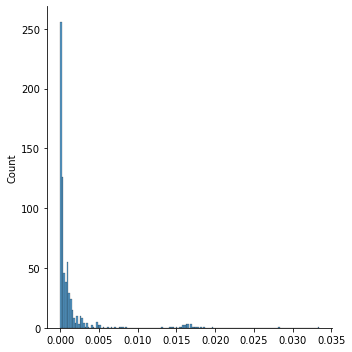

In [22]:
sns.displot(feat_importance_values) # most features do not impact model

# HistGradientBoosting

In [23]:
%%time
# can do grid search to fine tune hyperparams
hgb = HistGradientBoostingClassifier(max_depth=15, scoring='roc_auc',verbose = 1)
clf = hgb.fit(X_train, y_train)

clf.score(X_train, y_train)

Binning 1.071 GB of training data: 8.876 s
Binning 0.119 GB of validation data: 0.246 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 8, train score: 0.70968, val score: 0.71281, in 0.355s
[2/100] 1 tree, 31 leaves, max depth = 9, train score: 0.71103, val score: 0.71752, in 0.344s
[3/100] 1 tree, 31 leaves, max depth = 8, train score: 0.71308, val score: 0.72217, in 0.356s
[4/100] 1 tree, 31 leaves, max depth = 9, train score: 0.71726, val score: 0.72571, in 0.381s
[5/100] 1 tree, 31 leaves, max depth = 9, train score: 0.72217, val score: 0.72910, in 0.383s
[6/100] 1 tree, 31 leaves, max depth = 8, train score: 0.72364, val score: 0.73130, in 0.372s
[7/100] 1 tree, 31 leaves, max depth = 10, train score: 0.72607, val score: 0.73263, in 0.371s
[8/100] 1 tree, 31 leaves, max depth = 8, train score: 0.72849, val score: 0.73469, in 0.384s
[9/100] 1 tree, 31 leaves, max depth = 9, train score: 0.73133, val score: 0.73644, in 0.378s
[10/100] 1 tree, 31 leaves, max 

[86/100] 1 tree, 31 leaves, max depth = 12, train score: 0.80281, val score: 0.76915, in 0.421s
[87/100] 1 tree, 31 leaves, max depth = 10, train score: 0.80340, val score: 0.76920, in 0.425s
[88/100] 1 tree, 31 leaves, max depth = 11, train score: 0.80392, val score: 0.76929, in 0.368s
[89/100] 1 tree, 31 leaves, max depth = 15, train score: 0.80482, val score: 0.76924, in 0.382s
[90/100] 1 tree, 31 leaves, max depth = 11, train score: 0.80518, val score: 0.76917, in 0.326s
[91/100] 1 tree, 31 leaves, max depth = 12, train score: 0.80565, val score: 0.76942, in 0.410s
[92/100] 1 tree, 31 leaves, max depth = 12, train score: 0.80638, val score: 0.76949, in 0.333s
[93/100] 1 tree, 31 leaves, max depth = 11, train score: 0.80685, val score: 0.76947, in 0.316s
[94/100] 1 tree, 31 leaves, max depth = 13, train score: 0.80742, val score: 0.76966, in 0.380s
[95/100] 1 tree, 31 leaves, max depth = 13, train score: 0.80824, val score: 0.76958, in 0.383s
[96/100] 1 tree, 31 leaves, max depth = 

0.9213777020027223

In [24]:
clf

HistGradientBoostingClassifier(max_depth=15, scoring='roc_auc', verbose=1)

In [25]:
clf.score(X_test, y_test)

0.9197866759164914

In [26]:
y_prob_hgb = clf.predict_proba(X_test)[:,1]

In [27]:
roc_auc_hgb = roc_auc_score(y_test,y_prob_hgb)
roc_auc_hgb

0.7629614850297578

0.7638817947220536

In [28]:
filename = 'finalized_hgb_model.sav'
pickle.dump(clf, open(filename, 'wb'))

In [29]:
loaded_model = pickle.load(open(filename, 'rb'))
result_prob = loaded_model.predict_proba(X_test)[:,1]
result = roc_auc_score(y_test,result_prob)
print(result)

0.7629614850297578


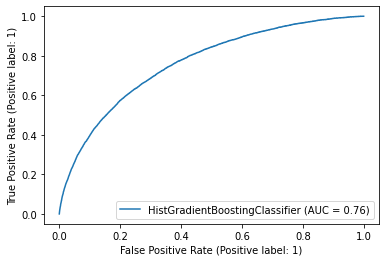

In [30]:
plot_roc_curve(clf, X_test, y_test)  

# Submission

In [31]:
%%time
data = Data()
df_dict = data.get_data()

CPU times: user 27.5 s, sys: 3.35 s, total: 30.9 s
Wall time: 31.7 s


In [32]:
app_test = df_dict['application_test']

In [33]:
%%time
df_test = merge_dfs(df_app="application_test", verbose=True)

Aggregating non-application dataframes...
application_train:       122 --> 72. Dropped 50 columns
application_test:       121 --> 71. Dropped 50 columns
previous_application:       37 --> 26. Dropped 11 columns
Loading credit card balance data table...
23 --> 23. Dropped 0 columns
optimized size by 26.0 % | 0.0103558 GB
Loading 'bureau' AND 'bureau_balance' data tables...
Running get_bureau_final function...
Running get_bureau_balance_final function...
optimized size by 65.99999999999999 % | 0.156472346 GB
Loading isntallments payments data table...
8 --> 8. Dropped 0 columns
optimized size by 19.999999999999996 % | 0.010866784 GB
Loading POS_CASH_balance data table...
8 --> 8. Dropped 0 columns
optimized size by 32.99999999999999 % | 0.010792064 GB
application_train:       72 --> 72. Dropped 0 columns
application_test:       71 --> 71. Dropped 0 columns
previous_application:       26 --> 26. Dropped 0 columns
credit_card_balance:       23 --> 16. Dropped 7 columns
bureau:       505 --

In [34]:
df_test = df_test.replace(to_replace=np.inf,value=np.nan).replace(to_replace=-np.inf,value=np.nan)

In [35]:
X_test = df_test.drop(columns=["SK_ID_CURR"])

In [36]:
a = X_test.copy()

In [37]:
b = preproc.transform(a)

In [38]:
print(X_transformed.shape)
print(b.shape)

(307511, 691)
(48744, 691)


In [40]:
%%time
# Retrained model based on optimised parameters
hgb = HistGradientBoostingClassifier(max_depth=15, max_iter = 20_000, scoring = 'roc_auc',verbose = 1)
model_hgb = hgb.fit(X_transformed, y)

Binning 1.530 GB of training data: 11.415 s
Binning 0.170 GB of validation data: 0.395 s
Fitting gradient boosted rounds:
[1/20000] 1 tree, 31 leaves, max depth = 8, train score: 0.69561, val score: 0.69861, in 0.494s
[2/20000] 1 tree, 31 leaves, max depth = 9, train score: 0.69903, val score: 0.70691, in 0.478s
[3/20000] 1 tree, 31 leaves, max depth = 9, train score: 0.70050, val score: 0.71019, in 0.480s
[4/20000] 1 tree, 31 leaves, max depth = 9, train score: 0.70741, val score: 0.71120, in 0.496s
[5/20000] 1 tree, 31 leaves, max depth = 9, train score: 0.71048, val score: 0.71392, in 0.497s
[6/20000] 1 tree, 31 leaves, max depth = 8, train score: 0.71406, val score: 0.71572, in 0.515s
[7/20000] 1 tree, 31 leaves, max depth = 8, train score: 0.71690, val score: 0.71695, in 0.524s
[8/20000] 1 tree, 31 leaves, max depth = 11, train score: 0.71881, val score: 0.72023, in 0.488s
[9/20000] 1 tree, 31 leaves, max depth = 9, train score: 0.72274, val score: 0.72279, in 0.479s
[10/20000] 1 

[84/20000] 1 tree, 31 leaves, max depth = 14, train score: 0.78762, val score: 0.76344, in 0.445s
[85/20000] 1 tree, 31 leaves, max depth = 9, train score: 0.78774, val score: 0.76347, in 0.485s
[86/20000] 1 tree, 31 leaves, max depth = 12, train score: 0.78839, val score: 0.76345, in 0.402s
[87/20000] 1 tree, 31 leaves, max depth = 9, train score: 0.78860, val score: 0.76362, in 0.538s
[88/20000] 1 tree, 31 leaves, max depth = 10, train score: 0.78887, val score: 0.76365, in 0.447s
[89/20000] 1 tree, 31 leaves, max depth = 12, train score: 0.78960, val score: 0.76375, in 0.428s
[90/20000] 1 tree, 31 leaves, max depth = 11, train score: 0.78978, val score: 0.76376, in 0.573s
[91/20000] 1 tree, 31 leaves, max depth = 13, train score: 0.79032, val score: 0.76381, in 0.512s
[92/20000] 1 tree, 31 leaves, max depth = 9, train score: 0.79097, val score: 0.76373, in 0.534s
[93/20000] 1 tree, 31 leaves, max depth = 12, train score: 0.79140, val score: 0.76396, in 0.521s
[94/20000] 1 tree, 31 l

In [46]:
filename = 'finalized_hgb_model.sav'
pickle.dump(model_hgb, open(filename, 'wb'))

In [41]:
%%time
hgb_pred = model_hgb.predict_proba(b)[:,1]

CPU times: user 3.2 s, sys: 381 ms, total: 3.58 s
Wall time: 667 ms


In [44]:
submit = df_test[['SK_ID_CURR']]
submit['TARGET'] = hgb_pred
print(submit.head())
print(submit.shape)

   SK_ID_CURR    TARGET
0      100001  0.067817
1      100005  0.196298
2      100013  0.020908
3      100028  0.033838
4      100038  0.145111
(48744, 2)


<ipython-input-44-fec20039861a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit['TARGET'] = hgb_pred


In [45]:
submit.to_csv('hgb_hcdr.csv',index=False)

# other work

In [ ]:
# parameters = {
#     "loss":['auto', 'binary_crossentropy', 'categorical_crossentropy'],
#     "max_iter": [50,100,150],
#     "min_samples_leaf": np.linspace(1,5,12),
#     "max_depth":[8,12,15],
#     "scoring": ['roc_auc']
#     }

# clf = GridSearchCV(HistGradientBoostingClassifier(verbose = 1), parameters, cv=3, n_jobs=-1)

In [ ]:
# HistGradientBoostingClassifier().get_params().keys()

In [ ]:
# %%time
# clf.fit(X_train, y_train)
# print(clf.score(X_train, y_train))
# print(clf.best_params_)

In [ ]:
# plot_roc_curve(clf, X_test, y_test)  

In [ ]:
# plot_precision_recall_curve(clf,X_test,y_test)

In [ ]:
# plot_confusion_matrix(clf, X_test, y_test)  
# plt.show()  

In [ ]:
#sklearn wrapper